In [1]:
!wget "https://raw.githubusercontent.com/RadimKozl/OpenCV_Project4/main/notebooks/img/OpenCV_logo.png" -O /kaggle/working/OpenCV_logo.png

--2024-08-08 21:34:11--  https://raw.githubusercontent.com/RadimKozl/OpenCV_Project4/main/notebooks/img/OpenCV_logo.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3983 (3.9K) [image/png]
Saving to: '/kaggle/working/OpenCV_logo.png'

/kaggle/working/Ope 100%[===================>]   3.89K  --.-KB/s    in 0s      

2024-08-08 21:34:12 (31.2 MB/s) - '/kaggle/working/OpenCV_logo.png' saved [3983/3983]



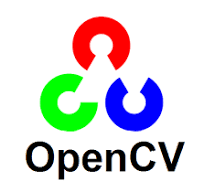

In [2]:
from IPython.display import Image
Image(filename = "/kaggle/working/OpenCV_logo.png", width=200, height=200)

# ***Video Face Mask Detection***
--------------------------------------

### ***Install libraries***

In [3]:
!pip install ultralytics
!pip install supervision
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 579.7 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.5/865.5 kB 5.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 1.4 MB/s eta 0:00:00 0:00:010m


## ***Import libraries***

In [4]:
import supervision as sv
import numpy as np
from ultralytics import YOLO

from IPython.display import display
import pickle, cv2, sys, os, csv

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, Output
from ipywidgets.widgets.interaction import interactive
from IPython.display import display

## ***Load models***

In [5]:
path_model_dir = '/kaggle/input/yolo-face-mask-detection-models/onnx/default/1/pt'

In [6]:
def load_file(path_dir, suffix='.pt'):
    list_files = os.listdir(path_dir)
    list_models_files = [file for file in list_files if os.path.isfile(os.path.join(path_dir, file)) and file.endswith(suffix)]
    return list_models_files

In [7]:
models_names = load_file(path_model_dir, suffix='.pt')
models_names

['YOLOv10m_FMD.pt',
 'YOLOv8m_FMD.pt',
 'YOLOv6m_FMD.pt',
 'YOLOv5m_FMD.pt',
 'YOLOv7_FMD.pt',
 'YOLOv9m_FMD.pt']

In [8]:
if not os.path.exists('/kaggle/working/pickle/'):
    os.mkdir('/kaggle/working/pickle/') 
    
PICKLE_PATH = '/kaggle/working/pickle/'

In [9]:
def sel_model(name):
    path = os.path.join(path_model_dir,name)
    data = (name, path)
    file_path = os.path.join(PICKLE_PATH, 'sel_model.pkl')
    with open(file_path, 'wb') as f:  
        pickle.dump(data, f)
    return data

In [10]:
path_model = interact(sel_model, name=models_names);

interactive(children=(Dropdown(description='name', options=('YOLOv10m_FMD.pt', 'YOLOv8m_FMD.pt', 'YOLOv6m_FMD.…

In [63]:
with open(os.path.join(PICKLE_PATH, 'sel_model.pkl'), 'rb') as f:
    sel_model = pickle.load(f)

## ***Create model***

In [64]:
model = YOLO(sel_model[1])

## ***Videos***

In [65]:
path_dir_videos = '/kaggle/input/face-mask-detection-test-opencv-university/test_dataset/videos'

In [66]:
videos_names = load_file(path_dir_videos, suffix='.mp4')
videos_names

['test-video2.mp4', 'test-video1.mp4']

In [67]:
def sel_video(name):
    path = os.path.join(path_dir_videos,name)
    data = (name, path)
    file_path = os.path.join(PICKLE_PATH, 'sel_video.pkl')
    with open(file_path, 'wb') as f:  
        pickle.dump(data, f)
    return data

In [68]:
path_video = interact(sel_video, name=videos_names);

interactive(children=(Dropdown(description='name', options=('test-video2.mp4', 'test-video1.mp4'), value='test…

In [74]:
with open(os.path.join(PICKLE_PATH, 'sel_video.pkl'), 'rb') as f:
    sel_video = pickle.load(f)

In [75]:
video_info = sv.VideoInfo.from_video_path(sel_video[1])

## ***Create a Video Processing Callback***

In [76]:

def process_frame(frame: np.ndarray, _) -> np.ndarray:
    results = model(frame, imgsz=640)[0]
    
    detections = sv.Detections.from_ultralytics(results)

    box_annotator = sv.BoxAnnotator(thickness=4)

    # Anotace pouze ohraničujících boxů
    frame = box_annotator.annotate(scene=frame, detections=detections)

    # Ruční přidání štítků
    for (box, confidence, class_name) in zip(detections.xyxy, detections.confidence, detections.data['class_name']):
        x1, y1, x2, y2 = map(int, box)
        label = f"{class_name} {confidence:.2f}"
        # Přidání textu na obrázek
        cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    return frame

In [77]:
if not os.path.exists('/kaggle/working/results/'):
    os.mkdir('/kaggle/working/results/') 
    
PATH_RESULTS = '/kaggle/working/results/'

In [78]:
%%time
name_model_text = sel_model[0].split('.')[0]
sv.process_video(source_path=sel_video[1], target_path=os.path.join(PATH_RESULTS,'resuls_ultralytics_'+name_model_text+'_'+sel_video[0]), callback=process_frame);


0: 352x640 1 mask, 4 no-masks, 500.5ms
Speed: 2.6ms preprocess, 500.5ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 mask, 4 no-masks, 471.7ms
Speed: 2.7ms preprocess, 471.7ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 mask, 4 no-masks, 478.3ms
Speed: 3.5ms preprocess, 478.3ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 mask, 4 no-masks, 478.9ms
Speed: 2.4ms preprocess, 478.9ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 mask, 5 no-masks, 477.5ms
Speed: 2.5ms preprocess, 477.5ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 mask, 4 no-masks, 482.6ms
Speed: 2.8ms preprocess, 482.6ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 mask, 4 no-masks, 478.7ms
Speed: 3.6ms preprocess, 478.7ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 mask, 4 no-masks, 49